# Test the Experiment and Analysis classes (under development)

In [ ]:
# set up non-QM hardware
import Labber
# connect to server 
client = Labber.connectToServer('localhost') # get list of instruments 
#instruments = client.getListOfInstrumentsString() 
#for instr in instruments: 
#    print(instr) # close connection 

# reset all QDevil channels to 0 V
QDevil = client.connectToInstrument('QDevil QDAC', dict(interface='Serial', address='3'))
for n in range(24):
    if n+1 < 10:
        QDevil.setValue("CH0" + str(n+1) + " Voltage", 0.0)
    else:
        QDevil.setValue("CH" + str(n+1) + " Voltage", 0.0)

# Set qubits to desired dc value
QDevil.setValue("CH01 Voltage", 0.6)

# digital attenuators
Vaunix1 = client.connectToInstrument('Painter Vaunix Lab Brick Digital Attenuator', dict(interface='USB', address='25606'))
Vaunix2 = client.connectToInstrument('Painter Vaunix Lab Brick Digital Attenuator', dict(interface='USB', address='25607'))
ROI = 32
ROO = 10
Vaunix1.setValue("Attenuation", ROI)
Vaunix2.setValue("Attenuation", ROO)

# TWPA pump
SG = client.connectToInstrument('Rohde&Schwarz RF Source', dict(interface='TCPIP', address='192.168.88.2'))
freq_TWPA = 6326E6;
pwr_TWPA = -10;
SG.setValue('Frequency', freq_TWPA)
SG.setValue('Power', pwr_TWPA)

client.close()

In [1]:
from qm.qua import *
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm import SimulationConfig, LoopbackInterface
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from qm import SimulationConfig
from qualang_tools.bakery import baking
from qualang_tools.units import unit
import qdac as qdac
from scipy.io import savemat
from scipy.io import loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
import datetime 
import os
import time
import warnings
from qm import generate_qua_script
from qm.octave import QmOctaveConfig
from qm.octave.octave_manager import ClockMode
from typing import Union
import json
from set_octave import ElementsSettings, octave_settings
from quam import QuAM

warnings.filterwarnings("ignore")

def wait_until_job_is_paused(current_job):
    """
    Waits until the OPX FPGA reaches the pause statement.
    Used when the OPX sequence needs to be synchronized with an external parameter sweep.

    :param current_job: the job object.
    """
    while not current_job.is_paused():
        time.sleep(0.01)
        pass
    return True

qubit_index = 0 # for UA Q1

now = datetime.datetime.now()
year = now.strftime("%Y")
month = now.strftime("%m")
day = now.strftime("%d")

tPath = os.path.join(r'Z:\LabberData_DF5\QM_Data_DF5',year,month,'Data_'+month+day)
if not os.path.exists(tPath):
   os.makedirs(tPath)

2023-10-19 15:44:06,350 - qm - INFO     - Starting session: b4200d09-1b84-487d-8923-d1855622068a


In [2]:
from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

In [3]:
Experiment = ExperimentHandle()
Analysis = AnalysisHandle()

In [ ]:
Experiment.exp1D.Rabi.qubit_freq(np.arange(6.5E9, 6.6E9, 1e6),qubit_index = 0,res_index = 0,flux_index = 0,n_avg = 100,cd_time = 20E3,ff_amp = 1,tPath = None,f_str_datetime = None,simulate_flag = True,simulation_len = 1000)

In [ ]:
Experiment.exp2D.RR.rr_vs_dc_flux(res_freq_sweep=np.arange(7E9, 7.1E9, 1e6),dc_flux_sweep=[0],qubit_index = 0,res_index = 0,flux_index = 0,n_avg = 100,cd_time = 20E3,tPath = None,f_str_datetime = None,simulate_flag = True,simulation_len = 10000)

In [ ]:
help(update_frequency)

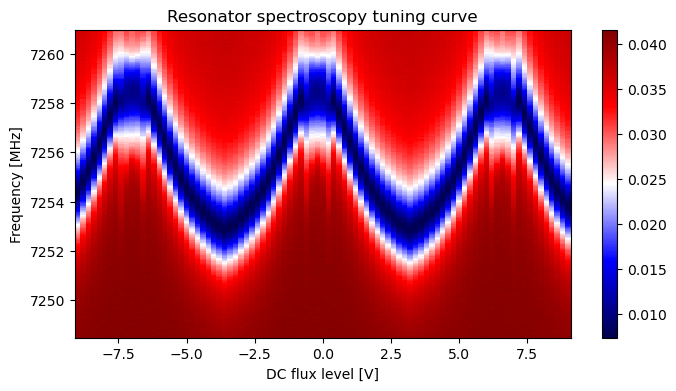

In [4]:
RR_freq_sweep = np.arange(-7.5e6, 5e6, 0.05e6)
file_name = 'UA_Q1_RR_spec_flux_sweep_0906-1243'
data = loadmat(os.path.join(r"Z:\LabberData_DF5\QM_Data_DF5\2023\09\Data_0906", file_name))
freq = data['RR_freq'][0]
sig_amp = data['sig_amp'][0]
dc_flux_sweep = data['dc_flux_sweep'][0]

fig = plt.figure(figsize=[8, 4])
sig = np.reshape(sig_amp, (np.size(dc_flux_sweep), np.size(machine.resonators[qubit_index].f_readout + RR_freq_sweep)))

plt.rcParams['figure.figsize'] = [8, 4]
plt.cla()

# 2D spectroscopy plot
plt.title("Resonator spectroscopy tuning curve")
plt.pcolormesh( np.linspace(np.min(dc_flux_sweep), np.max(dc_flux_sweep), np.size(dc_flux_sweep)),
               np.linspace(np.min(machine.resonators[qubit_index].f_readout + RR_freq_sweep), 
                           np.max(machine.resonators[qubit_index].f_readout + RR_freq_sweep), 
                           np.size(machine.resonators[qubit_index].f_readout + RR_freq_sweep))/1e6, 
               sig.T, shading="nearest", cmap="seismic")
plt.xlabel("DC flux level [V]")
plt.ylabel("Frequency [MHz]")
plt.colorbar()
plt.show()

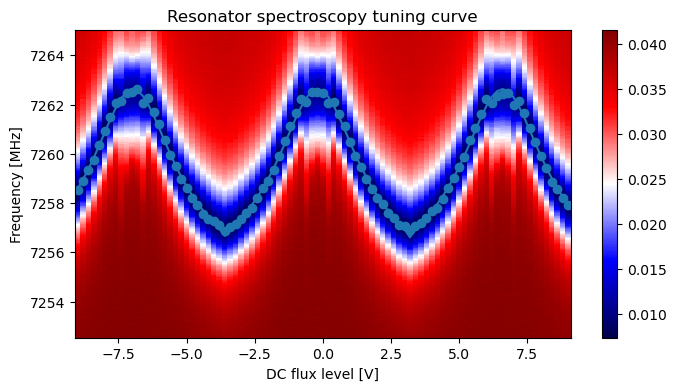

In [5]:
Analysis.ham_param = Analysis.exp2D.rr_vs_dc_flux(freq,dc_flux_sweep,sig_amp)

In [6]:
Analysis.ham_param

array([7.25549949e+03, 1.68684134e+02, 2.96402250e+04, 7.37165575e-02,
       8.62838232e-02, 8.88291497e+01])

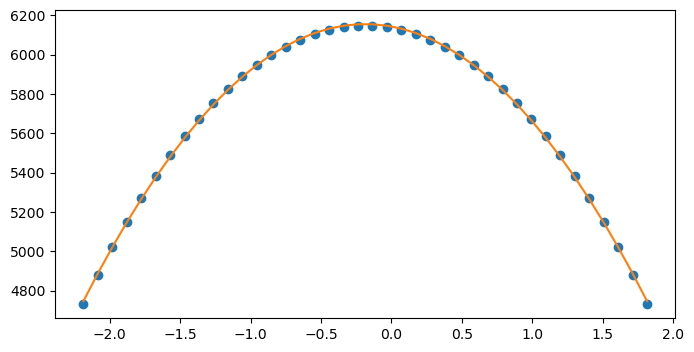

In [10]:
Analysis.poly_param = Analysis.exp2D.qubit_vs_dc_flux_guess(Analysis.ham_param)

In [ ]:
machine = Analysis.get_machine()

In [ ]:
machine.flux_lines[0].iswap.length